In [1]:
import torch
import numpy as np
from pathlib import Path
from agent import DQN
import random
import matplotlib.pyplot as plt
import tqdm
from environment import DuplicatedCoordsEnv
import pandas as pd
from environment import DuplicatedCoordsEnv
import itertools
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import normalize, StandardScaler

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
save_path = Path("save")
save_path.exists()

True

In [4]:
data_dir_lr = save_path / "7-21-LR"
data_dir_ew = save_path / "7-8-EW"
print(data_dir_lr.exists())
print(data_dir_ew.exists())

True
True


In [5]:
data_path_lr = data_dir_lr / "data.tar" 
print(data_path_lr.exists())
data_path_ew = data_dir_ew / "data.tar"
print(data_path_ew.exists())

True
True


In [6]:
data_dict_lr = torch.load(data_path_lr, weights_only=False, map_location=DEVICE)
data_dict_lr.keys()
data_dict_ew = torch.load(data_path_ew, weights_only=False, map_location=DEVICE)
data_dict_ew.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'all_qvalues', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

In [7]:
# ASSUMING EQUAL ARCHITECTURES
parameters = data_dict_lr['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units

In [8]:
model = DQN(n_observations, n_actions, n_units)

In [9]:
env = data_dict_lr['env'] # assuming equal environments

## Obtaining All Possible States

In [10]:
all_x = [-2, -1, 0, 1, 2]
all_y = [-2, -1, 0, 1, 2]
all_head = [0, 90, 180, 270]
all_odor = [torch.tensor(0), torch.tensor(1), torch.tensor(2)]

all_possible_states = list(itertools.product(all_odor, all_x, all_y, all_head))

state_dicts = [
    {'cue': odor, 'x': x, 'y': y, 'direction': hd}
    for (odor, x, y, hd) in all_possible_states
]

In [11]:
# 300 possible different states

print(len(all_possible_states))

300


In [12]:
# THINK ABOUT EDGE CASE WHERE AGENT SPAWNS ON TOP OF ODOR PORT

print(state_dicts)

[{'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': 2, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': 2, 'direction': 90}, {'cue': tensor(0

In [13]:
all_possible_tensors = []

for state_dict in state_dicts:
    state_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(env, state_dict)
    all_possible_tensors.append(state_tensor)

In [14]:
print(all_possible_tensors)

[tensor([ 1.0000e+00,  0.0000e+00,  0.0000e+00,  4.0000e+00,  4.0000e+00,
        -0.0000e+00, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  5.6569e+00,  7.0711e-01,  7.0711e-01, -7.0711e-01,
        -7.0711e-01,  0.0000e+00,  1.0000e+00,  0.0000e+00, -4.3711e-08,
         1.0000e+00]), tensor([ 1.0000e+00,  0.0000e+00,  0.0000e+00,  4.0000e+00,  4.0000e+00,
        -1.0000e+00,  4.3711e-08,  0.0000e+00,  0.0000e+00,  1.0000e+00,
        -4.3711e-08,  5.6569e+00,  7.0711e-01,  7.0711e-01, -7.0711e-01,
         7.0711e-01,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
        -4.3711e-08]), tensor([ 1.0000e+00,  0.0000e+00,  0.0000e+00,  4.0000e+00,  4.0000e+00,
         8.7423e-08,  1.0000e+00,  0.0000e+00,  0.0000e+00, -8.7423e-08,
        -1.0000e+00,  5.6569e+00,  7.0711e-01,  7.0711e-01,  7.0711e-01,
         7.0711e-01,  0.0000e+00,  1.0000e+00,  0.0000e+00, -4.3711e-08,
        -1.0000e+00]), tensor([ 1.0000e+00,  0.0000e+00,  0.0000e+00,  4.0000

## Activation t-SNE Plots

In [18]:
"""
Function for converting angle degree to cardinal direction
"""
def degrees_to_cardinal(degree):
    # Normalize the degree to [0, 360)
    degree = degree % 360

    # Define the mapping
    directions = {
        0: 'N',
        90: 'E',
        180: 'S',
        270: 'W'
    }

    # Find the closest cardinal angle
    closest = min(directions.keys(), key=lambda x: abs(x - degree))
    return directions[closest]

In [19]:
def convert_state_sample_to_orig_sample(state_sample):
    orig_state_samples = []
    for state in state_sample:

        if state[0].item() == 1:
            odor_cue = 'No Odor'
        elif state[1].item() == 1:
            odor_cue = 'Odor A'
        else:
            odor_cue = 'Odor B'

        coords_orig = env.conv_north_cartesian2orig(state[3:7]).tolist()
        coords_orig.insert(0, odor_cue)
        
        head_deg = coords_orig[3]
        head_cardinal = degrees_to_cardinal(head_deg)
        coords_orig[3] = head_cardinal

        orig_state_samples.append(coords_orig)
    return orig_state_samples

In [20]:
def get_layer_activations(net, input_states, layer_index):
    activations_list = []

    def hook(module, input, output):
        activations_list.append(output.detach().cpu().numpy().squeeze())

    # Register hook
    handle = list(net.mlp.children())[layer_index].register_forward_hook(hook)

    # Forward pass through each input state
    with torch.no_grad():
        for state in input_states:
            net(state)

    # Clean up hook
    handle.remove()

    # Stack into numpy array
    activations_array = np.stack(activations_list)  # Shape: (500, 512)

    return activations_array


In [21]:
def compute_centroids_by_category(activations, labels):
    centroids = {}
    for label in np.unique(labels):
        mask = labels == label
        centroids[label] = activations[mask].mean(axis=0)
    return centroids

### Sampling States : Think Carefully

In [25]:
state_samples = all_possible_tensors

In [26]:
orig_samples = convert_state_sample_to_orig_sample(state_sample=state_samples)

In [27]:
metadata = {
    "odor": [],
    "x": [],
    "y": [],
    "grid_pos": [],
    "head_dir": [],
    # You can add more fields like distance_to_port or shap_action later
}

for state in orig_samples:
    metadata["odor"].append(state[0])
    metadata["x"].append(state[1])
    metadata["y"].append(state[2])
    metadata["grid_pos"].append((state[1], state[2]))
    metadata["head_dir"].append(state[3])

metadata_df = pd.DataFrame(metadata)
print(metadata_df.to_string())

        odor    x    y      grid_pos head_dir
0    No Odor -2.0 -2.0  (-2.0, -2.0)        N
1    No Odor -2.0 -2.0  (-2.0, -2.0)        E
2    No Odor -2.0 -2.0  (-2.0, -2.0)        S
3    No Odor -2.0 -2.0  (-2.0, -2.0)        W
4    No Odor -2.0 -1.0  (-2.0, -1.0)        N
5    No Odor -2.0 -1.0  (-2.0, -1.0)        E
6    No Odor -2.0 -1.0  (-2.0, -1.0)        S
7    No Odor -2.0 -1.0  (-2.0, -1.0)        W
8    No Odor -2.0  0.0   (-2.0, 0.0)        N
9    No Odor -2.0  0.0   (-2.0, 0.0)        E
10   No Odor -2.0  0.0   (-2.0, 0.0)        S
11   No Odor -2.0  0.0   (-2.0, 0.0)        W
12   No Odor -2.0  1.0   (-2.0, 1.0)        N
13   No Odor -2.0  1.0   (-2.0, 1.0)        E
14   No Odor -2.0  1.0   (-2.0, 1.0)        S
15   No Odor -2.0  1.0   (-2.0, 1.0)        W
16   No Odor -2.0  2.0   (-2.0, 2.0)        N
17   No Odor -2.0  2.0   (-2.0, 2.0)        E
18   No Odor -2.0  2.0   (-2.0, 2.0)        S
19   No Odor -2.0  2.0   (-2.0, 2.0)        W
20   No Odor -1.0 -2.0  (-1.0, -2.

In [28]:
cat = data_dir_lr

if cat == data_dir_lr:
    cat_label = 'L/R'
else:
    cat_label = 'E/W'

model = DQN(n_observations, n_actions, n_units)

model_path = cat / f'trained-agent-state-0.pt'
model.load_state_dict(torch.load(model_path, weights_only=False, map_location=torch.device('cpu')))
model.eval()

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [29]:
layer_idx = 7

layer_activations = get_layer_activations(model, state_samples, layer_idx)

In [47]:
print(layer_activations.shape)

(300, 512)


In [48]:
print(layer_activations)

[[-0.33107287 -0.36008793 -0.36622828 ...  0.05955459 -0.5530473
  -0.28421724]
 [-0.36342597 -0.40106514 -0.39517838 ...  0.03144366 -0.44635767
  -0.30294055]
 [-0.30115885 -0.2822483  -0.4960168  ...  0.16367836 -0.37105757
  -0.27365294]
 ...
 [ 0.45530686 -0.9655882  -0.14933251 ... -0.21528365 -0.9655339
   0.13682869]
 [ 0.50117517 -0.79587716 -0.18941587 ... -0.06623486 -1.2820271
   0.01326513]
 [ 0.458853   -0.6975514  -0.24871501 ... -0.02561821 -1.3498396
   0.16651702]]


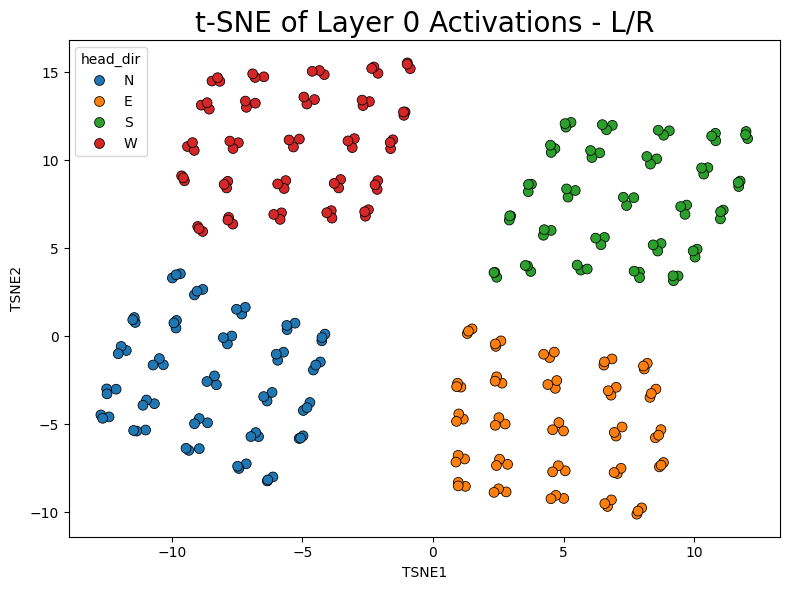

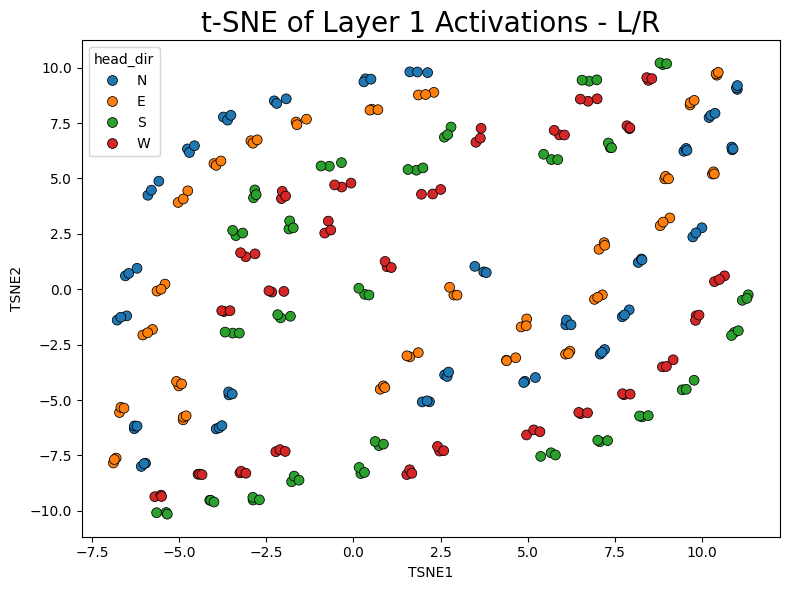

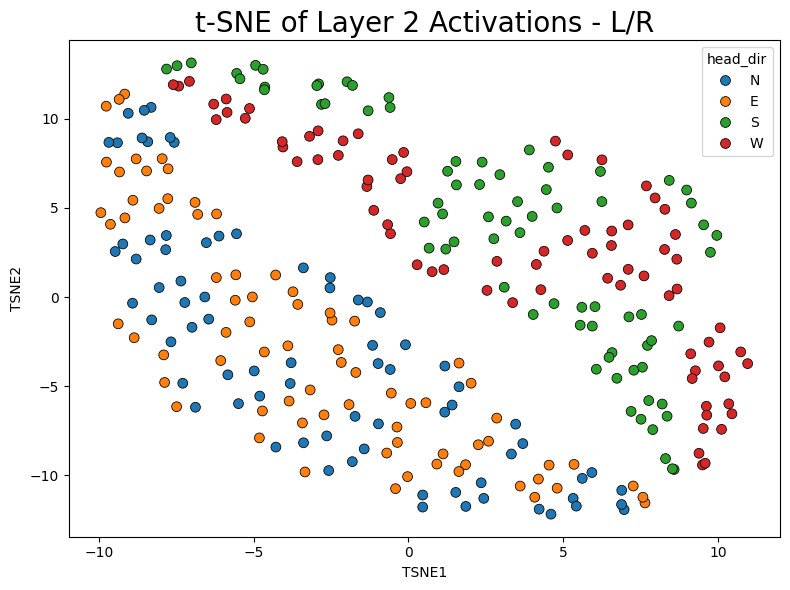

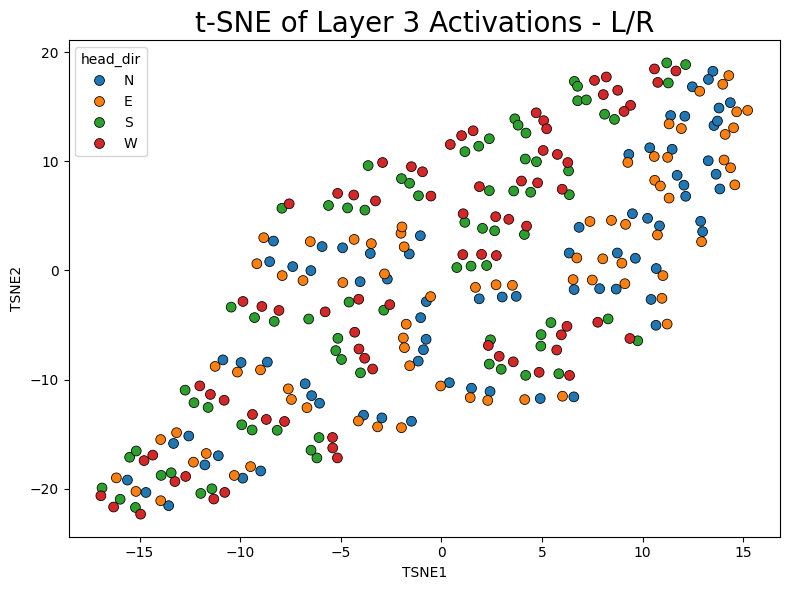

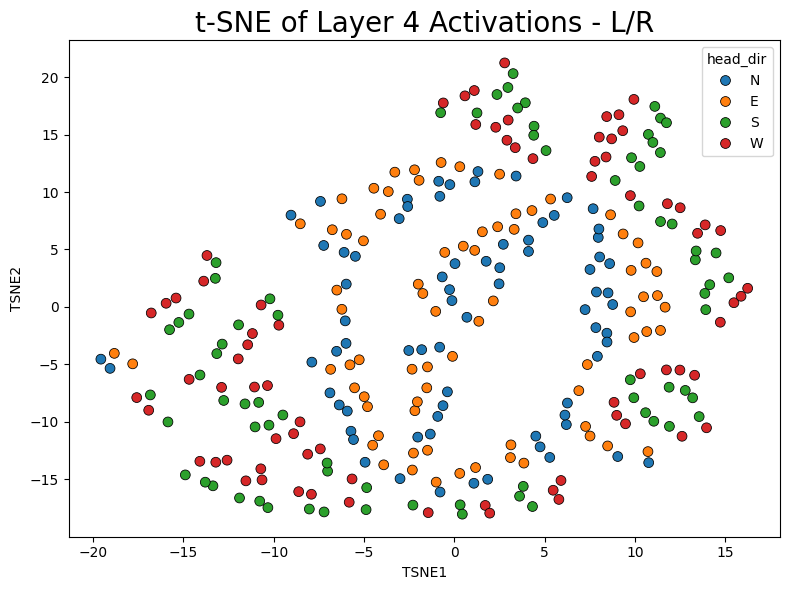

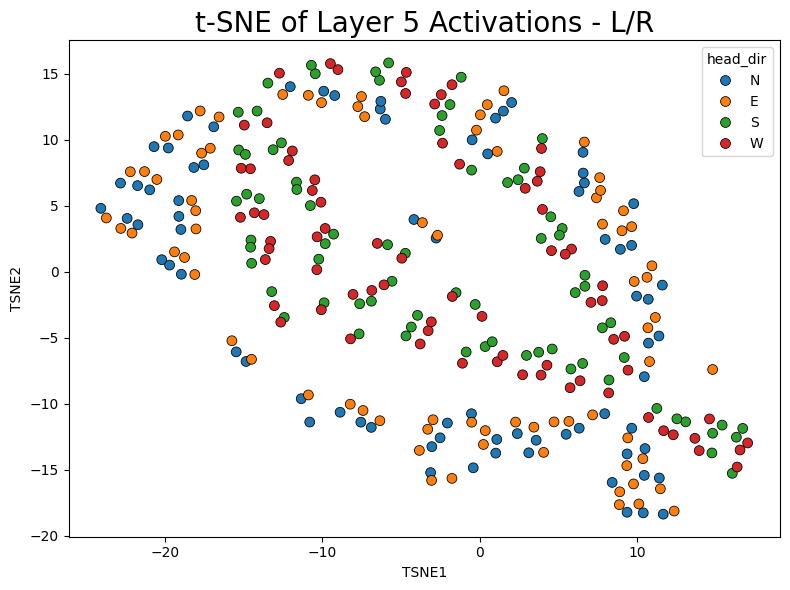

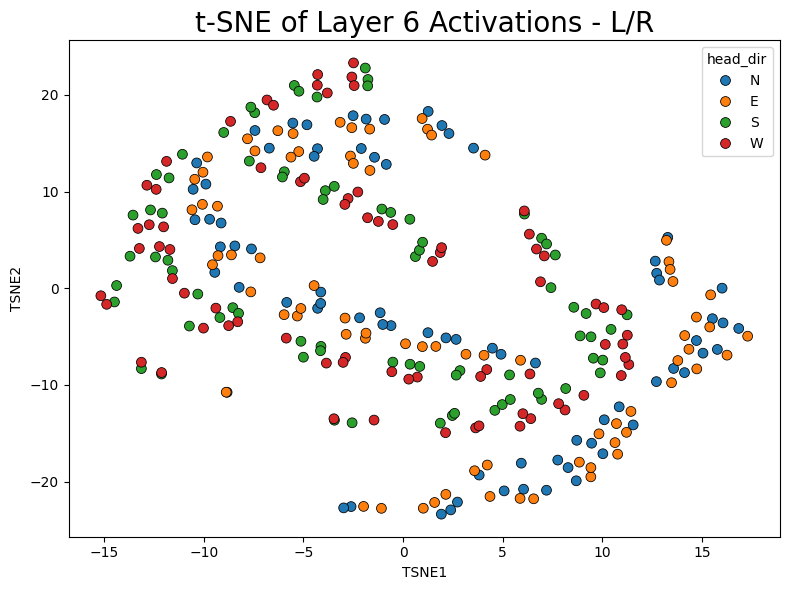

In [104]:
from sklearn.manifold import TSNE
import seaborn as sns

for layer_idx in range(7):

    layer_activations = get_layer_activations(model, state_samples, layer_idx)


    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='random', random_state=42, max_iter=5000)
    activations_2d = tsne.fit_transform(layer_activations) 

    tsne_df = pd.DataFrame(activations_2d, columns=["TSNE1", "TSNE2"])
    full_df = pd.concat([tsne_df, metadata_df], axis=1)


    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=full_df, x="TSNE1", y="TSNE2", hue="head_dir", palette="tab10",s=50,edgecolor='k')
    plt.title(f"t-SNE of Layer {layer_idx} Activations - {cat_label}", fontsize=20)
    plt.tight_layout()
    plt.savefig(f'figures/layer{layer_idx}LRHEADtSNE.png', dpi=300, bbox_inches='tight')
    plt.show()

In [85]:
layer_idx = 7

layer_activations = get_layer_activations(model, state_samples, layer_idx)

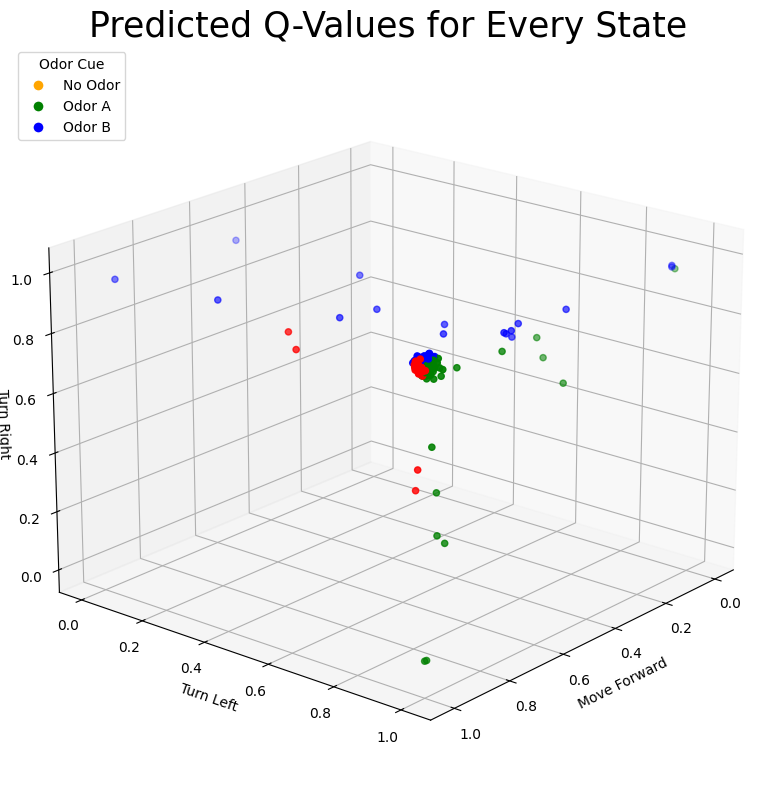

In [31]:
#Your custom label-to-color mapping
label_colors = {
    'No Odor': 'orange',
    'Odor A': 'green',
    'Odor B': 'blue'
}

# label_colors = {
#     -2: 'blue',
#     -1: 'orange',
#      0: 'green',
#      1: 'red',
#      2: 'purple'
# }

# label_colors = {
#     'N': 'blue',
#     'E': 'orange',
#     'S': 'green',
#     'W': 'red'
# }

# Get color for each point based on its label
colors = metadata_df['odor'].map(label_colors)


chosen_actions = np.argmax(layer_activations, axis=1)
action_colors = ['red', 'green', 'blue']
point_colors = [action_colors[a] for a in chosen_actions]

# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(layer_activations[:, 0], layer_activations[:, 1], layer_activations[:, 2], color=point_colors)

#Custom legend using same color mapping
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=8)
    for label, color in label_colors.items()
]
ax.legend(handles=legend_elements, title="Odor Cue", loc='upper left')

# Labels and title
ax.set_xlabel('Move Forward')
#ax.set_xlim(0.94, 1)
ax.set_ylabel('Turn Left')
#ax.set_ylim(0.94, 1)
ax.set_zlabel('Turn Right', labelpad=0.005)
#ax.set_zlim(0.94, 1)
plt.title("Predicted Q-Values for Every State", fontsize=25)
# Manually adjust space around the plot
plt.subplots_adjust(left=0.9, right=1.5, bottom=0.1, top=0.9)
ax.view_init(elev=20, azim=40)  # Change angles as needed
plt.tight_layout()
#plt.savefig('figures/3DactionsHEAD.png', dpi=300, bbox_inches='tight')
plt.show()

# IDEA: show the states that have low Q-values
# think about the optimal action thing: ChatGPT


In [ ]:
# CONSIDER EXPERT Q-VALUES
# CONSIDER Q-VALUE CONFIDENCE

(0.9, 1.0)

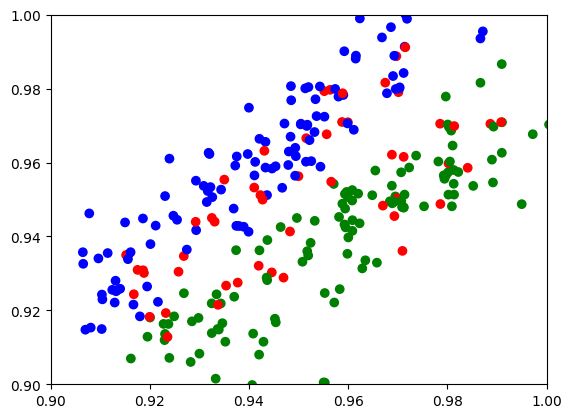

In [124]:
plt.scatter(layer_activations[:, 1], layer_activations[:, 2], color=point_colors)
plt.xlim(0.9, 1)
plt.ylim(0.9, 1)

In [89]:
print(layer_activations)

[[ 9.3230522e-01  9.6579093e-01  9.3290740e-01]
 [ 9.3127334e-01  9.3974286e-01  9.6229547e-01]
 [ 9.6021521e-01  9.4210333e-01  9.6641207e-01]
 [ 9.5013344e-01  9.4459647e-01  9.3027300e-01]
 [ 9.2420506e-01  9.4083768e-01  9.1370493e-01]
 [ 9.3725073e-01  9.3260008e-01  9.5063871e-01]
 [ 9.5618725e-01  9.3251419e-01  9.4500691e-01]
 [ 9.4353306e-01  9.5527297e-01  9.2468745e-01]
 [ 9.1586816e-01  9.3247795e-01  9.2189324e-01]
 [ 9.2310327e-01  9.3148667e-01  9.4930619e-01]
 [ 9.4657469e-01  9.2685801e-01  9.3469423e-01]
 [ 9.3424755e-01  9.4540423e-01  9.1675597e-01]
 [ 9.0936095e-01  9.2276710e-01  9.1634160e-01]
 [ 8.9195704e-01  9.0650064e-01  9.3573236e-01]
 [ 9.3585235e-01  9.1677791e-01  9.2436039e-01]
 [ 9.2356372e-01  9.3523318e-01  9.1151029e-01]
 [ 9.0973270e-01  9.1030598e-01  9.1494685e-01]
 [ 9.1467488e-01  9.1044348e-01  9.2298025e-01]
 [ 9.2626107e-01  9.2823714e-01  9.0603727e-01]
 [ 9.1356850e-01  9.2297858e-01  9.1194618e-01]
 [ 8.9136875e-01  9.5529211e-01  9.00442

### Extracting States with Odd Q-Values

In [76]:
q_val_threshold = 0.8

# Get indices of inner lists where *any* value is below the threshold
indices = [i for i, inner in enumerate(layer_activations) if any(val < q_val_threshold for val in inner)]

In [77]:
print(indices)

[112, 113, 114, 115, 116, 117, 118, 119, 180, 181, 182, 183, 184, 185, 186, 187, 216, 217, 218, 219, 236, 237, 239, 260, 261, 262, 263, 280, 281, 282, 283]


In [78]:
subset_df = metadata_df.iloc[indices]
print(subset_df.to_string())

       odor    x    y     grid_pos head_dir
112  Odor A -2.0  1.0  (-2.0, 1.0)        N
113  Odor A -2.0  1.0  (-2.0, 1.0)        E
114  Odor A -2.0  1.0  (-2.0, 1.0)        S
115  Odor A -2.0  1.0  (-2.0, 1.0)        W
116  Odor A -2.0  2.0  (-2.0, 2.0)        N
117  Odor A -2.0  2.0  (-2.0, 2.0)        E
118  Odor A -2.0  2.0  (-2.0, 2.0)        S
119  Odor A -2.0  2.0  (-2.0, 2.0)        W
180  Odor A  2.0 -2.0  (2.0, -2.0)        N
181  Odor A  2.0 -2.0  (2.0, -2.0)        E
182  Odor A  2.0 -2.0  (2.0, -2.0)        S
183  Odor A  2.0 -2.0  (2.0, -2.0)        W
184  Odor A  2.0 -1.0  (2.0, -1.0)        N
185  Odor A  2.0 -1.0  (2.0, -1.0)        E
186  Odor A  2.0 -1.0  (2.0, -1.0)        S
187  Odor A  2.0 -1.0  (2.0, -1.0)        W
216  Odor B -2.0  2.0  (-2.0, 2.0)        N
217  Odor B -2.0  2.0  (-2.0, 2.0)        E
218  Odor B -2.0  2.0  (-2.0, 2.0)        S
219  Odor B -2.0  2.0  (-2.0, 2.0)        W
236  Odor B -1.0  2.0  (-1.0, 2.0)        N
237  Odor B -1.0  2.0  (-1.0, 2.

In [ ]:
# again, why do I have the feeling that the agent is just randomly moving 
# around until it gets near a reward port, and then it is optimized to 
# make the right choice...

# perhaps the agent encodes exactly these extreme positions, and has
# optimized its weights/activations to make the right choice in literally
# every scenario

# but how can we prove that it doesn't have "paths?"

# also, how does it get the Odor initially? randomly?

# ask ChatGPT about this hypothesis

# get to the bottom of the NE / SW thing

## Fine-Grained Analysis: Zooming In

In [130]:
print(state_dicts)

[{'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': 2, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': 2, 'direction': 90}, {'cue': tensor(0

In [339]:
filtered_states = [state for state in state_dicts if state['cue'] == torch.tensor(1) and state['direction'] == 90]
print(filtered_states)
all_filtered_tensors = []

for state_dict in filtered_states:
    state_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(env, state_dict)
    all_filtered_tensors.append(state_tensor)
print(len(all_filtered_tensors))

[{'cue': tensor(1), 'x': -2, 'y': -2, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': -1, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': 0, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': 1, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': 2, 'direction': 90}, {'cue': tensor(1), 'x': -1, 'y': -2, 'direction': 90}, {'cue': tensor(1), 'x': -1, 'y': -1, 'direction': 90}, {'cue': tensor(1), 'x': -1, 'y': 0, 'direction': 90}, {'cue': tensor(1), 'x': -1, 'y': 1, 'direction': 90}, {'cue': tensor(1), 'x': -1, 'y': 2, 'direction': 90}, {'cue': tensor(1), 'x': 0, 'y': -2, 'direction': 90}, {'cue': tensor(1), 'x': 0, 'y': -1, 'direction': 90}, {'cue': tensor(1), 'x': 0, 'y': 0, 'direction': 90}, {'cue': tensor(1), 'x': 0, 'y': 1, 'direction': 90}, {'cue': tensor(1), 'x': 0, 'y': 2, 'direction': 90}, {'cue': tensor(1), 'x': 1, 'y': -2, 'direction': 90}, {'cue': tensor(1), 'x': 1, 'y': -1, 'direction': 90}, {'cue': tensor(1), 'x': 1, 'y': 0, 'direction': 90}, {'cue': tensor(1), 'x': 1, 

In [340]:
state_samples = all_filtered_tensors
orig_samples = convert_state_sample_to_orig_sample(state_sample=state_samples)
metadata = {
    "odor": [],
    "x": [],
    "y": [],
    "grid_pos": [],
    "head_dir": [],
    # You can add more fields like distance_to_port or shap_action later
}

for state in orig_samples:
    metadata["odor"].append(state[0])
    metadata["x"].append(state[1])
    metadata["y"].append(state[2])
    metadata["grid_pos"].append((state[1], state[2]))
    metadata["head_dir"].append(state[3])

metadata_df = pd.DataFrame(metadata)
print(metadata_df.to_string())

      odor    x    y      grid_pos head_dir
0   Odor A -2.0 -2.0  (-2.0, -2.0)        E
1   Odor A -2.0 -1.0  (-2.0, -1.0)        E
2   Odor A -2.0  0.0   (-2.0, 0.0)        E
3   Odor A -2.0  1.0   (-2.0, 1.0)        E
4   Odor A -2.0  2.0   (-2.0, 2.0)        E
5   Odor A -1.0 -2.0  (-1.0, -2.0)        E
6   Odor A -1.0 -1.0  (-1.0, -1.0)        E
7   Odor A -1.0  0.0   (-1.0, 0.0)        E
8   Odor A -1.0  1.0   (-1.0, 1.0)        E
9   Odor A -1.0  2.0   (-1.0, 2.0)        E
10  Odor A  0.0 -2.0   (0.0, -2.0)        E
11  Odor A  0.0 -1.0   (0.0, -1.0)        E
12  Odor A  0.0  0.0    (0.0, 0.0)        E
13  Odor A  0.0  1.0    (0.0, 1.0)        E
14  Odor A  0.0  2.0    (0.0, 2.0)        E
15  Odor A  1.0 -2.0   (1.0, -2.0)        E
16  Odor A  1.0 -1.0   (1.0, -1.0)        E
17  Odor A  1.0  0.0    (1.0, 0.0)        E
18  Odor A  1.0  1.0    (1.0, 1.0)        E
19  Odor A  1.0  2.0    (1.0, 2.0)        E
20  Odor A  2.0 -2.0   (2.0, -2.0)        E
21  Odor A  2.0 -1.0   (2.0, -1.

In [174]:
layer_idx = 0

layer_activations = get_layer_activations(model, state_samples, layer_idx)

In [175]:
print(layer_activations.shape)

(50, 512)


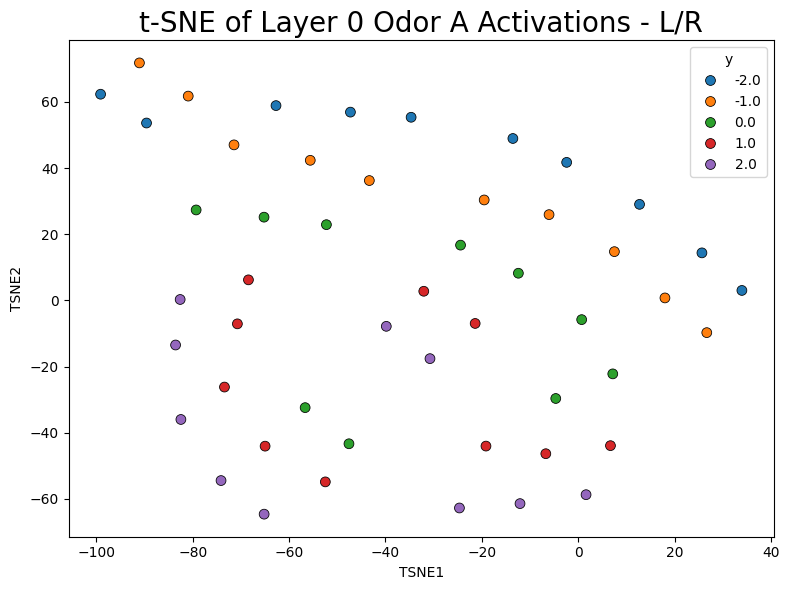

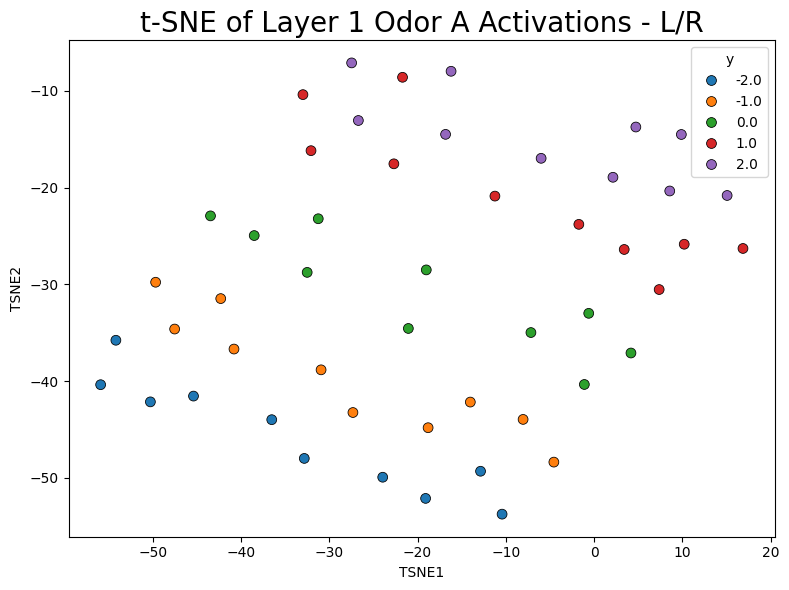

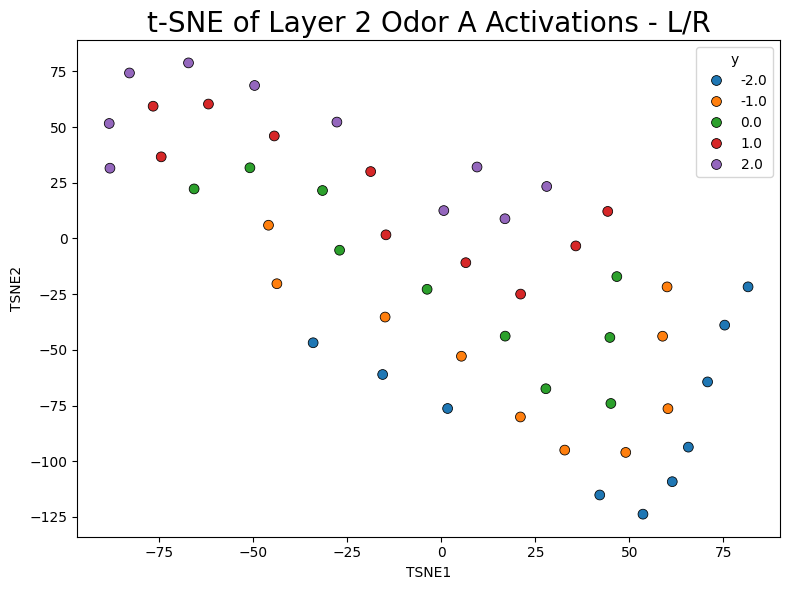

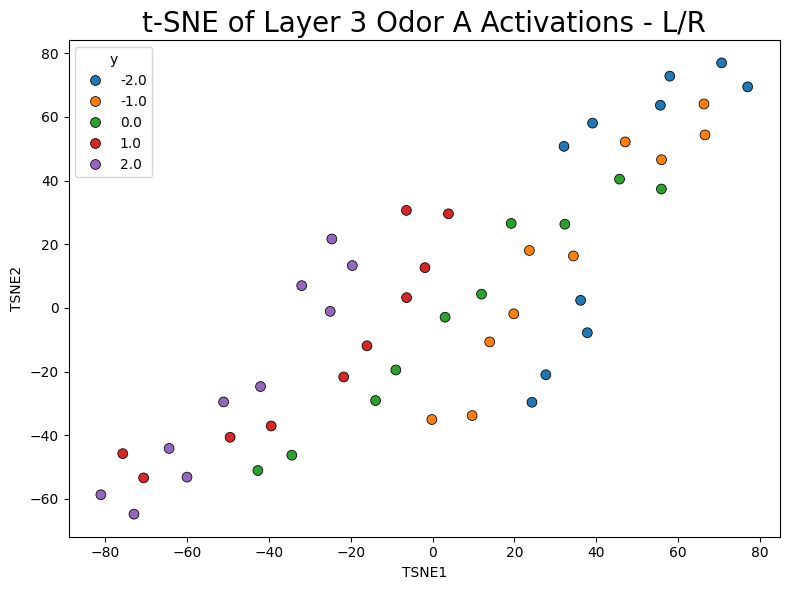

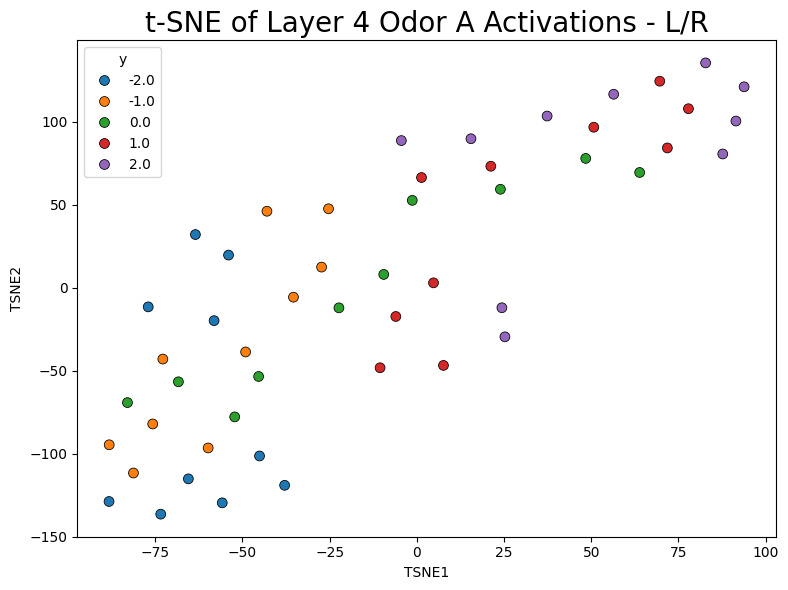

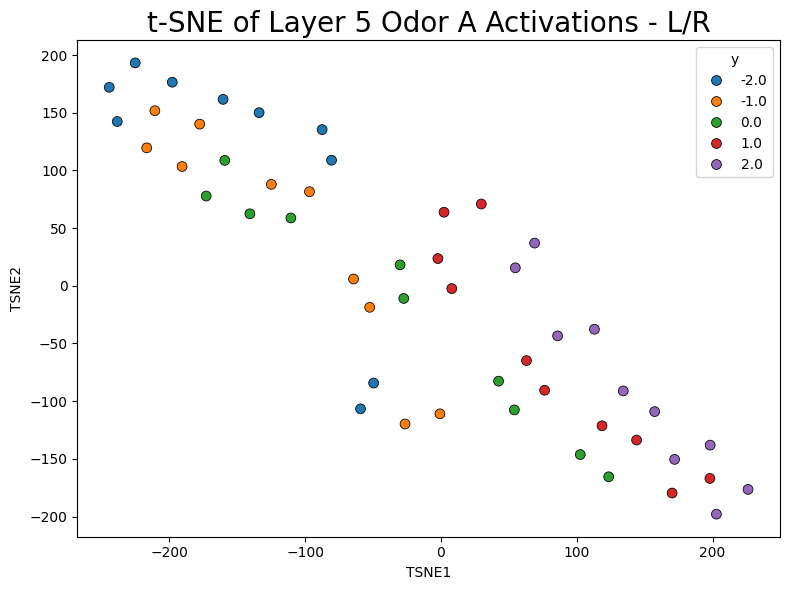

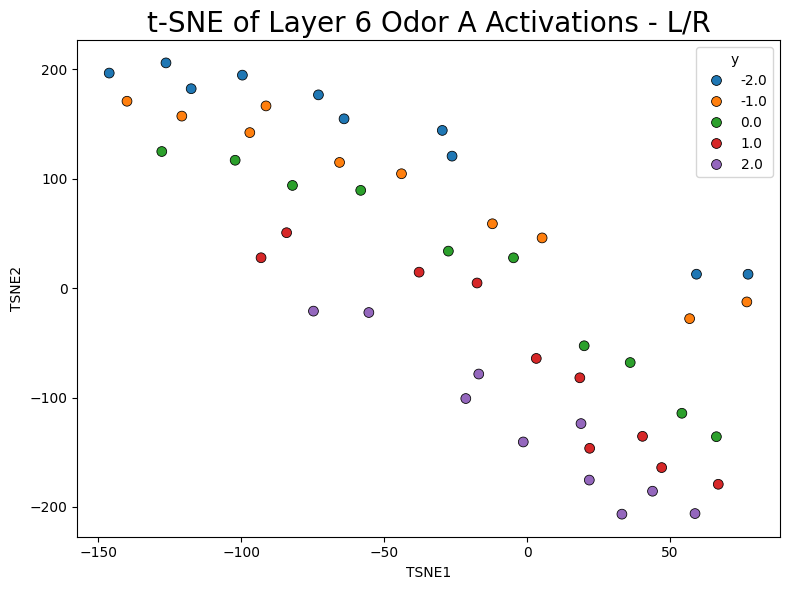

In [ ]:
for layer_idx in range(7):
#for p in [5, 10, 15, 30]:
    p=10
    layer_activations = get_layer_activations(model, state_samples, layer_idx)

    tsne = TSNE(n_components=2, perplexity=p, learning_rate=200, init='random', random_state=24, max_iter=5000)
    activations_2d = tsne.fit_transform(layer_activations) 

    tsne_df = pd.DataFrame(activations_2d, columns=["TSNE1", "TSNE2"])
    full_df = pd.concat([tsne_df, metadata_df], axis=1)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=full_df, x="TSNE1", y="TSNE2", hue="y", palette="tab10",s=50,edgecolor='k')
    plt.title(f"t-SNE of Layer {layer_idx} Odor A Activations - {cat_label}", fontsize=20)
    plt.tight_layout()
    #plt.savefig(f'figures/perp{p}layer{layer_idx}ANEY.png', dpi=300, bbox_inches='tight')
    plt.show()

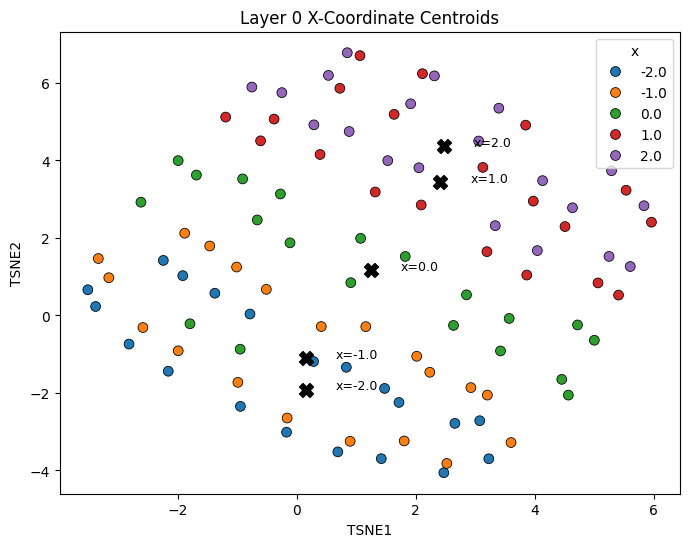

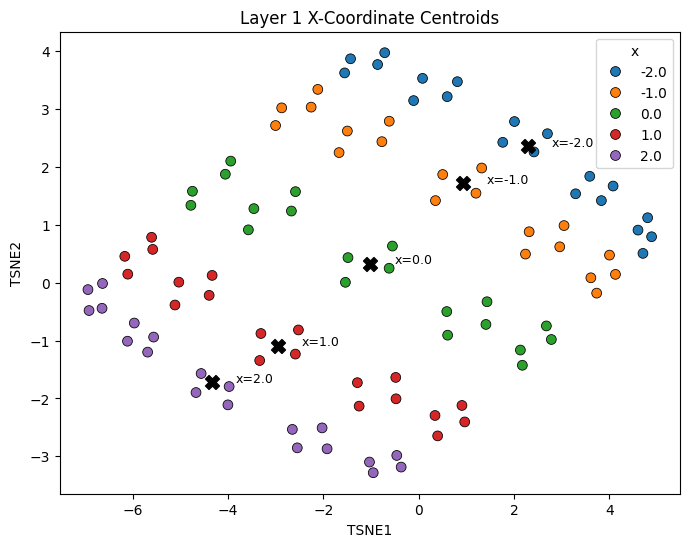

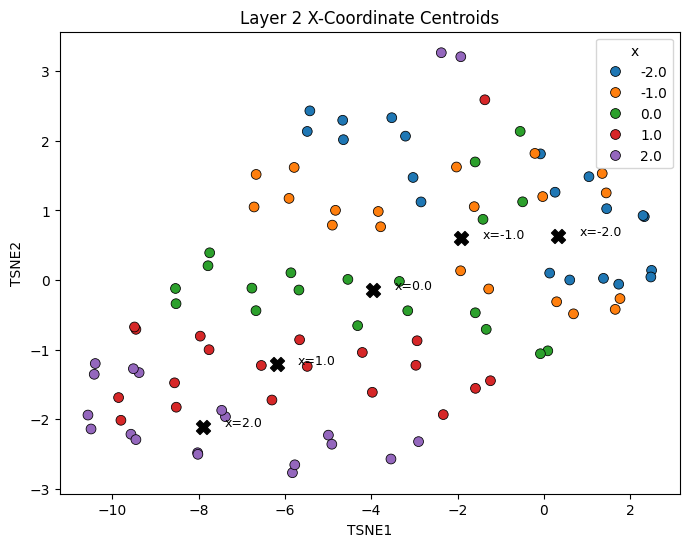

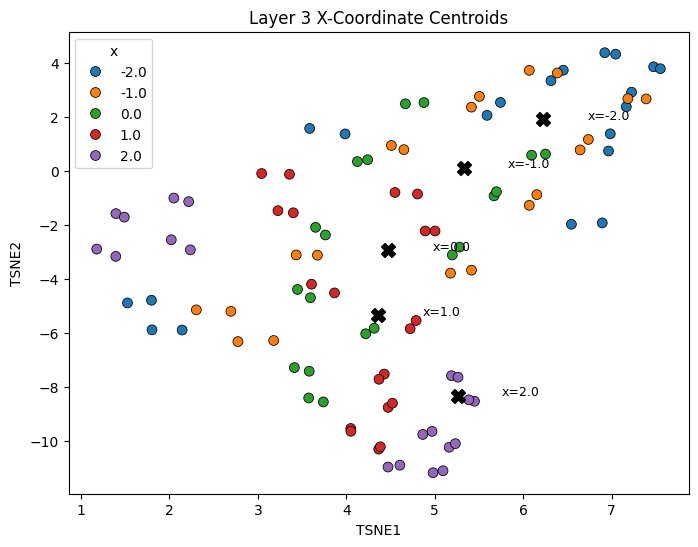

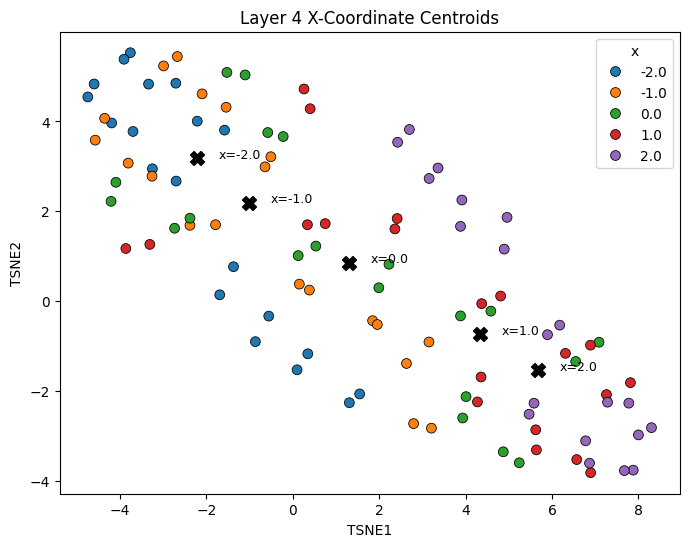

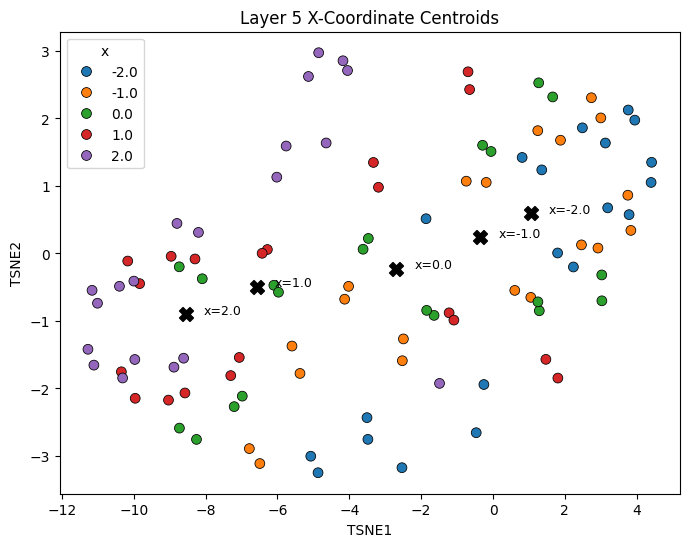

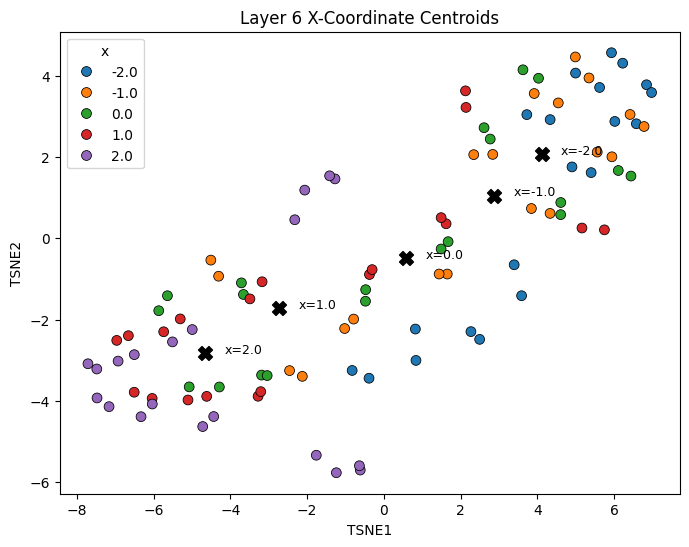

In [ ]:
for layer_idx in range(7):
#for p in [5, 10, 15, 30]:
    p=30
    layer_activations = get_layer_activations(model, state_samples, layer_idx)

    centroids_by_x = compute_centroids_by_category(activations=layer_activations, labels=x_coords)
    x_labels = sorted(centroids_by_x.keys())
    x_centroids = np.array([centroids_by_x[x] for x in x_labels])
    combined = np.vstack([layer_activations, x_centroids])

    tsne = TSNE(n_components=2, perplexity=p, learning_rate=200, init='random', random_state=42, max_iter=5000)
    activations_2d = tsne.fit_transform(combined) 

    tsne_df = pd.DataFrame(activations_2d, columns=["TSNE1", "TSNE2"])
    full_df = pd.concat([tsne_df, metadata_df], axis=1)

    # Split
    tsne_points = activations_2d[:len(layer_activations)]
    tsne_centroids = activations_2d[len(layer_activations):]

    fig, ax = plt.subplots(figsize=(8,6))
    #plt.figure(figsize=(8, 6))
    sns.scatterplot(data=full_df, x="TSNE1", y="TSNE2", hue="x", palette="tab10",s=50,edgecolor='k')

    # TODO: color the centroids by label; add colors to metadata df using label_to_colors dictionary

    for i, x in enumerate(x_labels):
        plt.scatter(tsne_centroids[i,0], tsne_centroids[i,1], c='black', marker='X', s=100)
        plt.text(tsne_centroids[i,0]+0.5, tsne_centroids[i,1], f'x={x}', fontsize=9)

    plt.title(f'Layer {layer_idx} X-Coordinate Centroids')
    ax.legend(title='x')
    plt.show()

In [341]:
layer_idx = 7

layer_activations = get_layer_activations(model, state_samples, layer_idx)

In [342]:
print(layer_activations.shape)

(25, 3)


In [343]:
print(metadata_df)

      odor    x    y      grid_pos head_dir
0   Odor A -2.0 -2.0  (-2.0, -2.0)        E
1   Odor A -2.0 -1.0  (-2.0, -1.0)        E
2   Odor A -2.0  0.0   (-2.0, 0.0)        E
3   Odor A -2.0  1.0   (-2.0, 1.0)        E
4   Odor A -2.0  2.0   (-2.0, 2.0)        E
5   Odor A -1.0 -2.0  (-1.0, -2.0)        E
6   Odor A -1.0 -1.0  (-1.0, -1.0)        E
7   Odor A -1.0  0.0   (-1.0, 0.0)        E
8   Odor A -1.0  1.0   (-1.0, 1.0)        E
9   Odor A -1.0  2.0   (-1.0, 2.0)        E
10  Odor A  0.0 -2.0   (0.0, -2.0)        E
11  Odor A  0.0 -1.0   (0.0, -1.0)        E
12  Odor A  0.0  0.0    (0.0, 0.0)        E
13  Odor A  0.0  1.0    (0.0, 1.0)        E
14  Odor A  0.0  2.0    (0.0, 2.0)        E
15  Odor A  1.0 -2.0   (1.0, -2.0)        E
16  Odor A  1.0 -1.0   (1.0, -1.0)        E
17  Odor A  1.0  0.0    (1.0, 0.0)        E
18  Odor A  1.0  1.0    (1.0, 1.0)        E
19  Odor A  1.0  2.0    (1.0, 2.0)        E
20  Odor A  2.0 -2.0   (2.0, -2.0)        E
21  Odor A  2.0 -1.0   (2.0, -1.

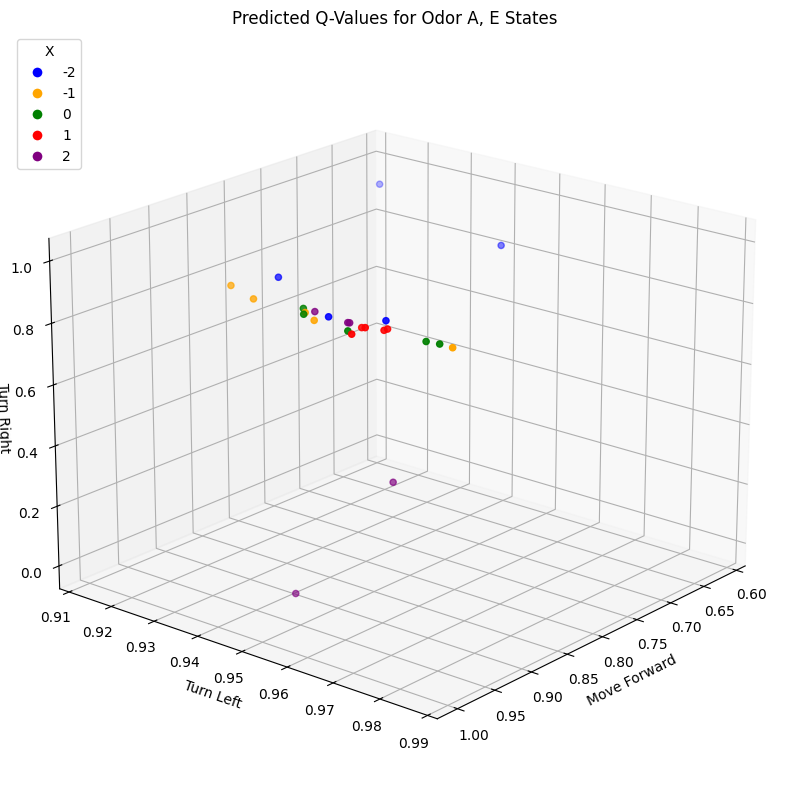

In [344]:
#Your custom label-to-color mapping
# label_colors = {
#     'No Odor': 'orange',
#     'Odor A': 'green',
#     'Odor B': 'blue'
# }

label_colors = {
    -2: 'blue',
    -1: 'orange',
     0: 'green',
     1: 'red',
     2: 'purple'
}

# label_colors = {
#     'N': 'blue',
#     'E': 'orange',
#     'S': 'green',
#     'W': 'red'
# }

# Get color for each point based on its label
colors = metadata_df['x'].map(label_colors)

# chosen_actions = np.argmax(layer_activations, axis=1)
# action_colors = ['red', 'green', 'blue']
# point_colors = [action_colors[a] for a in chosen_actions]

# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(layer_activations[:, 0], layer_activations[:, 1], layer_activations[:, 2], color=colors)

# Custom legend using same color mapping
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=8)
    for label, color in label_colors.items()
]
ax.legend(handles=legend_elements, title="X", loc='upper left')

# Labels and title
ax.set_xlabel('Move Forward')
#ax.set_xlim3d(0.94,1)
ax.set_ylabel('Turn Left')
#ax.set_ylim3d(0.94,1)
ax.set_zlabel('Turn Right', labelpad=0.005)
#ax.set_zlim3d(0.94,1)
plt.title("Predicted Q-Values for Odor A, E States")
# Manually adjust space around the plot
plt.subplots_adjust(left=0.9, right=1.5, bottom=0.1, top=0.9)
ax.view_init(elev=20, azim=40)  # Change angles as needed
plt.tight_layout()
plt.savefig('figures/3DAEactionsX.png', dpi=300, bbox_inches='tight')
plt.show()

# IDEA: show the states that have low Q-values
# think about the optimal action thing: ChatGPT


## PCA Analysis

In [183]:
cat = data_dir_lr

if cat == data_dir_lr:
    cat_label = 'L/R'
else:
    cat_label = 'E/W'

model = DQN(n_observations, n_actions, n_units)

model_path = cat / f'trained-agent-state-0.pt'
model.load_state_dict(torch.load(model_path, weights_only=False, map_location=torch.device('cpu')))
model.eval()

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [184]:
print(len(all_possible_tensors))

300


In [306]:
filtered_states = [state for state in state_dicts if state['cue'] == torch.tensor(1)]
print(filtered_states)
all_filtered_tensors = []

for state_dict in filtered_states:
    state_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(env, state_dict)
    all_filtered_tensors.append(state_tensor)
print(len(all_filtered_tensors))

[{'cue': tensor(1), 'x': -2, 'y': -2, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': -2, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': -2, 'direction': 180}, {'cue': tensor(1), 'x': -2, 'y': -2, 'direction': 270}, {'cue': tensor(1), 'x': -2, 'y': -1, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': -1, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': -1, 'direction': 180}, {'cue': tensor(1), 'x': -2, 'y': -1, 'direction': 270}, {'cue': tensor(1), 'x': -2, 'y': 0, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': 0, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': 0, 'direction': 180}, {'cue': tensor(1), 'x': -2, 'y': 0, 'direction': 270}, {'cue': tensor(1), 'x': -2, 'y': 1, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': 1, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': 1, 'direction': 180}, {'cue': tensor(1), 'x': -2, 'y': 1, 'direction': 270}, {'cue': tensor(1), 'x': -2, 'y': 2, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': 2, 'direction': 90}, {'cue': tensor(1

In [307]:
state_samples = all_filtered_tensors

In [308]:
q_values = get_layer_activations(model, state_samples, 7)
chosen_actions = np.argmax(q_values, axis=1)

action_labels = ['Move Forward', 'Turn Left', 'Turn Right']
chosen_action_names = [action_labels[i] for i in chosen_actions]

In [309]:
orig_samples = convert_state_sample_to_orig_sample(state_sample=state_samples)
metadata = {
    "odor": [],
    "x": [],
    "y": [],
    "grid_pos": [],
    "head_dir": [],
    "action": []
}

for state in orig_samples:
    metadata["odor"].append(state[0])
    metadata["x"].append(state[1])
    metadata["y"].append(state[2])
    metadata["grid_pos"].append((state[1], state[2]))
    metadata["head_dir"].append(state[3])
metadata["action"] = chosen_action_names

metadata_df = pd.DataFrame(metadata)
print(metadata_df.to_string())

      odor    x    y      grid_pos head_dir        action
0   Odor A -2.0 -2.0  (-2.0, -2.0)        N    Turn Right
1   Odor A -2.0 -2.0  (-2.0, -2.0)        E    Turn Right
2   Odor A -2.0 -2.0  (-2.0, -2.0)        S     Turn Left
3   Odor A -2.0 -2.0  (-2.0, -2.0)        W     Turn Left
4   Odor A -2.0 -1.0  (-2.0, -1.0)        N    Turn Right
5   Odor A -2.0 -1.0  (-2.0, -1.0)        E    Turn Right
6   Odor A -2.0 -1.0  (-2.0, -1.0)        S     Turn Left
7   Odor A -2.0 -1.0  (-2.0, -1.0)        W     Turn Left
8   Odor A -2.0  0.0   (-2.0, 0.0)        N    Turn Right
9   Odor A -2.0  0.0   (-2.0, 0.0)        E    Turn Right
10  Odor A -2.0  0.0   (-2.0, 0.0)        S     Turn Left
11  Odor A -2.0  0.0   (-2.0, 0.0)        W     Turn Left
12  Odor A -2.0  1.0   (-2.0, 1.0)        N    Turn Right
13  Odor A -2.0  1.0   (-2.0, 1.0)        E    Turn Right
14  Odor A -2.0  1.0   (-2.0, 1.0)        S  Move Forward
15  Odor A -2.0  1.0   (-2.0, 1.0)        W     Turn Left
16  Odor A -2.

In [310]:
print(state_samples)

[tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00,  4.0000e+00,  4.0000e+00,
        -0.0000e+00, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  5.6569e+00,  7.0711e-01,  7.0711e-01, -7.0711e-01,
        -7.0711e-01,  0.0000e+00,  1.0000e+00,  0.0000e+00, -4.3711e-08,
         1.0000e+00]), tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00,  4.0000e+00,  4.0000e+00,
        -1.0000e+00,  4.3711e-08,  0.0000e+00,  0.0000e+00,  1.0000e+00,
        -4.3711e-08,  5.6569e+00,  7.0711e-01,  7.0711e-01, -7.0711e-01,
         7.0711e-01,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
        -4.3711e-08]), tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00,  4.0000e+00,  4.0000e+00,
         8.7423e-08,  1.0000e+00,  0.0000e+00,  0.0000e+00, -8.7423e-08,
        -1.0000e+00,  5.6569e+00,  7.0711e-01,  7.0711e-01,  7.0711e-01,
         7.0711e-01,  0.0000e+00,  1.0000e+00,  0.0000e+00, -4.3711e-08,
        -1.0000e+00]), tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00,  4.0000

[0.4633617 0.2637423]
[0.64715356 0.23000951]
[0.56709814 0.11045291]
[0.6373511  0.12943123]
[0.53690976 0.1128704 ]
[0.58683294 0.12657695]
[0.5649324  0.10310865]


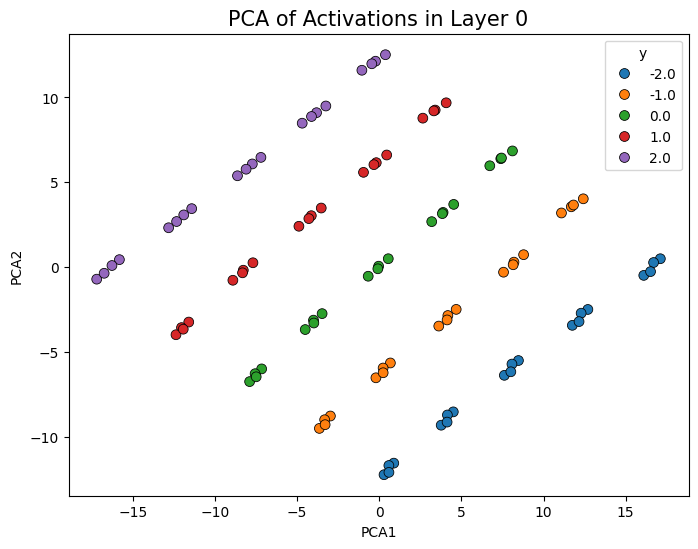

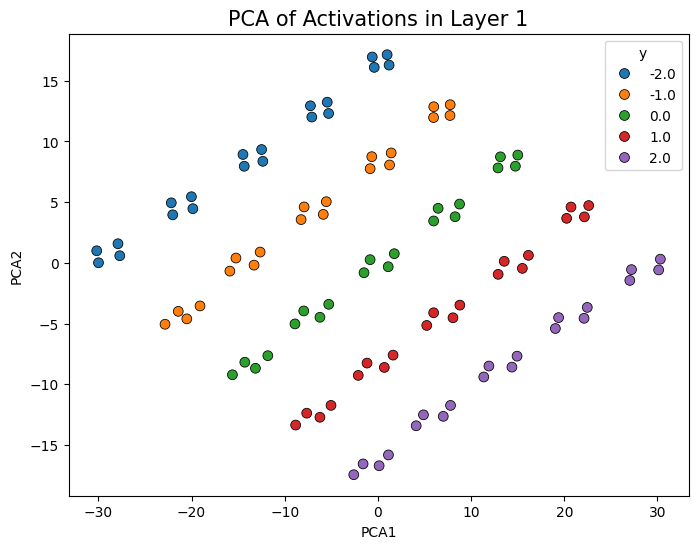

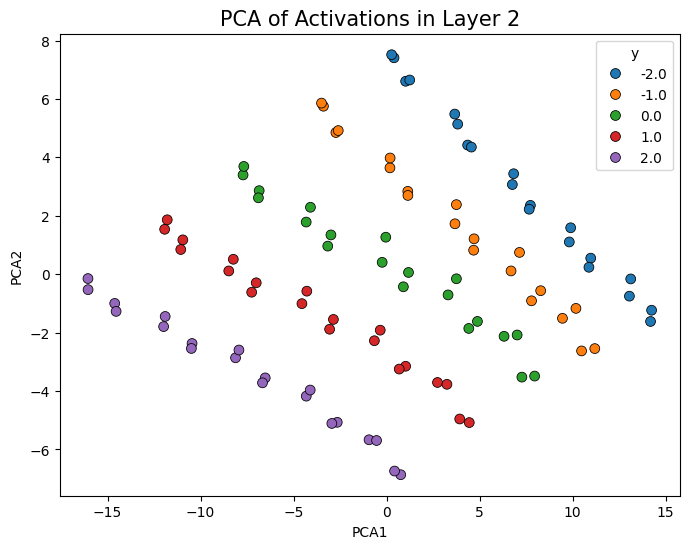

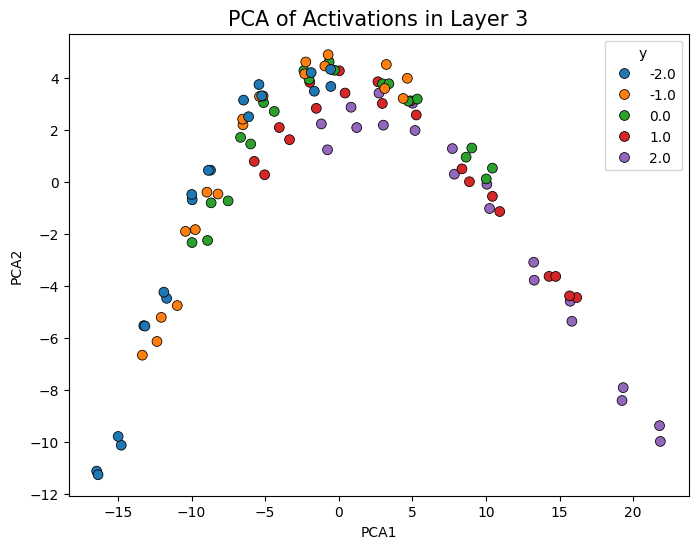

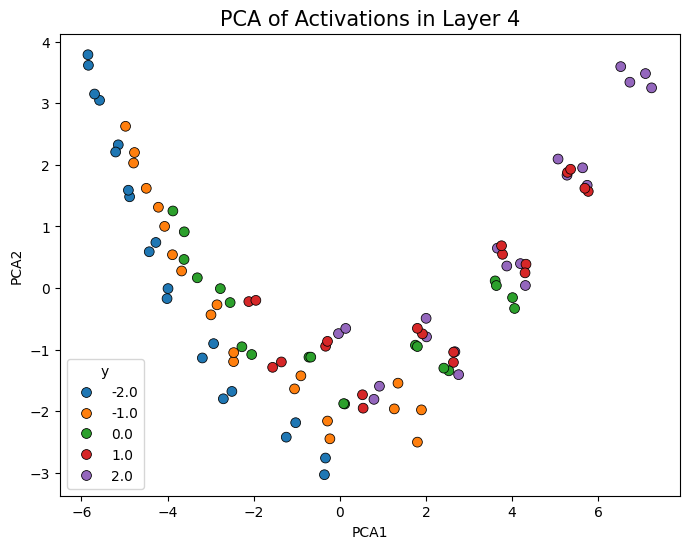

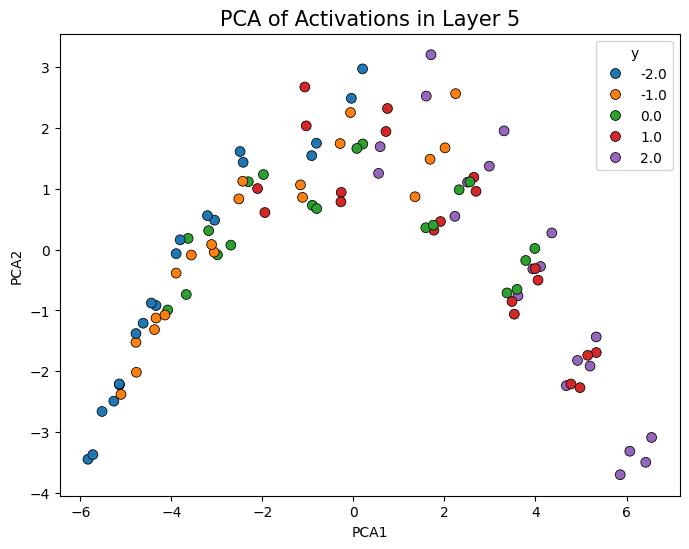

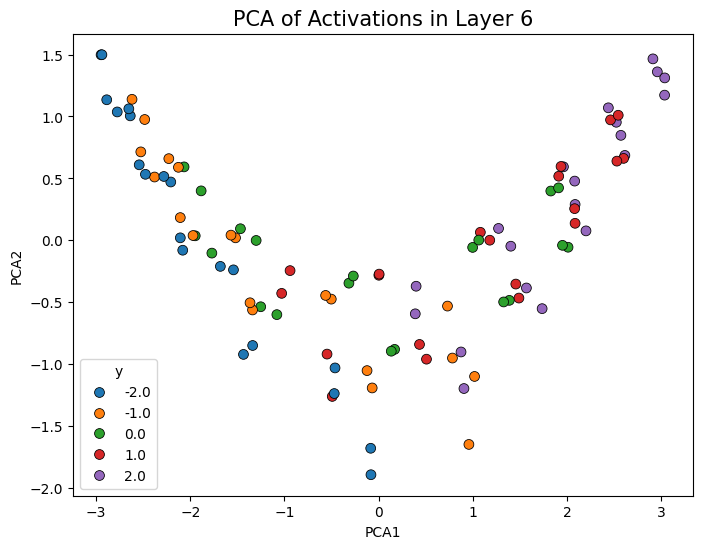

In [316]:
# layer_idx = 6

# layer_activations = get_layer_activations(model, state_samples, layer_idx)

for layer_idx in range(7):

    layer_activations = get_layer_activations(model, state_samples, layer_idx)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(layer_activations)  # shape (n_samples, 2)
    pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
    full_df = pd.concat([pca_df, metadata_df], axis=1)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.scatterplot(data=full_df, x="PCA1", y="PCA2", hue="y", palette="tab10",s=50,edgecolor='k')
    ax.set_title(f'PCA of Activations in Layer {layer_idx}', fontsize=15)
    plt.savefig(f'figures/ODORAlayer{layer_idx}PCAX.png', dpi=300, bbox_inches='tight')
    print(pca.explained_variance_ratio_)

In [266]:
heading_vectors = {
    'N': (0, 1),
    'E': (1, 0),
    'S': (0, -1),
    'W': (-1, 0)
}

def rotate_heading(current_heading, turn):
    directions = ['N', 'E', 'S', 'W']
    idx = directions.index(current_heading)
    
    if turn == 'Move Forward':
        return heading_vectors[current_heading]
    elif turn == 'Turn Left':
        return heading_vectors[directions[(idx - 1) % 4]]
    elif turn == 'Turn Right':
        return heading_vectors[directions[(idx + 1) % 4]]
    else:
        return (0, 0)  # Unknown action

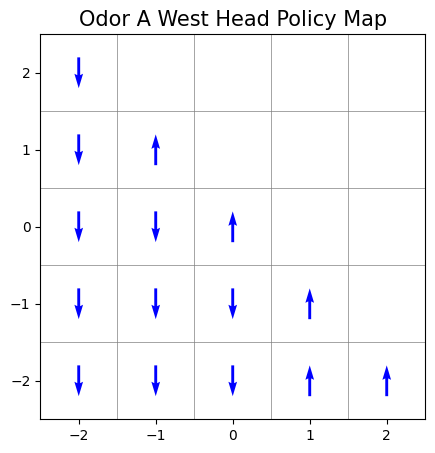

In [305]:
upper_triangle = False

if upper_triangle:
    filtered_df = metadata_df[metadata_df['y'] >= -metadata_df['x']]
else:
    filtered_df = metadata_df[metadata_df['y'] <= -metadata_df['x']]

# Prepare data for quiver
X = filtered_df['x'].values
Y = filtered_df['y'].values
U = []
V = []

for _, row in filtered_df.iterrows():
    heading = row['head_dir']
    action = row['action']
    dx, dy = rotate_heading(heading, action)
    U.append(dx)
    V.append(dy)

# Plot
fig, ax = plt.subplots(figsize=(5, 5))

# Draw grid lines BETWEEN cells
grid_range = np.arange(-2.5, 3, 1)
for g in grid_range:
    ax.axhline(g, color='gray', linewidth=0.5)
    ax.axvline(g, color='gray', linewidth=0.5)

# Draw arrows at the center of cells
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=2.5, color='blue', pivot='middle')

# Axis settings
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_xticks(np.arange(-2, 3, 1))
ax.set_yticks(np.arange(-2, 3, 1))
ax.set_aspect('equal')
ax.set_title("Odor A West Head Policy Map", fontsize=15)

# # Optional: center origin visually
# ax.spines['left'].set_position('zero')
# ax.spines['bottom'].set_position('zero')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.grid(False)
plt.savefig('figures/AWLPolicy.png', dpi=300, bbox_inches='tight')
plt.show()


In [333]:
# The fact that there's something about states at the extremes that activate similarily says something...?
# -----> link to the few states where Q-values drop
# And then there's a jumble in the middle with states from all over acting similarily...link to the Q-values all being high

# I DON"T UNDERSTAND HOW THE NETWORK LEARNS PATHS THOUGH

In [351]:
# the middle represents the diagonals
# as you go further in the interior of the grid, you get more similar activations
# ---> activations differ as you approach the corners, i.e. reward ports
# and the quadratic represents the opposite sides of the arena
# ---> so there 

# the fact that Odor A and Odor B are clustered together in the PCA means that it doesn't really activate differently based on Odor...is that true?
# ----> this contrasts the t-SNE where Odor points were clearly clustered together? Does it though?

## Centroids

In [15]:
cat = data_dir_lr

if cat == data_dir_lr:
    cat_label = 'L/R'
else:
    cat_label = 'E/W'

model = DQN(n_observations, n_actions, n_units)

model_path = cat / f'trained-agent-state-0.pt'
model.load_state_dict(torch.load(model_path, weights_only=False, map_location=torch.device('cpu')))
model.eval()

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [23]:
filtered_states = [state for state in state_dicts if state['cue'] == torch.tensor(1) and state['direction'] == 0]
print(filtered_states)
all_filtered_tensors = []

for state_dict in filtered_states:
    state_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(env, state_dict)
    all_filtered_tensors.append(state_tensor)
print(len(all_filtered_tensors))

[{'cue': tensor(1), 'x': -2, 'y': -2, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': -1, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': 0, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': 1, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': 2, 'direction': 0}, {'cue': tensor(1), 'x': -1, 'y': -2, 'direction': 0}, {'cue': tensor(1), 'x': -1, 'y': -1, 'direction': 0}, {'cue': tensor(1), 'x': -1, 'y': 0, 'direction': 0}, {'cue': tensor(1), 'x': -1, 'y': 1, 'direction': 0}, {'cue': tensor(1), 'x': -1, 'y': 2, 'direction': 0}, {'cue': tensor(1), 'x': 0, 'y': -2, 'direction': 0}, {'cue': tensor(1), 'x': 0, 'y': -1, 'direction': 0}, {'cue': tensor(1), 'x': 0, 'y': 0, 'direction': 0}, {'cue': tensor(1), 'x': 0, 'y': 1, 'direction': 0}, {'cue': tensor(1), 'x': 0, 'y': 2, 'direction': 0}, {'cue': tensor(1), 'x': 1, 'y': -2, 'direction': 0}, {'cue': tensor(1), 'x': 1, 'y': -1, 'direction': 0}, {'cue': tensor(1), 'x': 1, 'y': 0, 'direction': 0}, {'cue': tensor(1), 'x': 1, 'y': 1, 'direction

In [25]:
state_samples = all_filtered_tensors
orig_samples = convert_state_sample_to_orig_sample(state_sample=state_samples)
metadata = {
    "odor": [],
    "x": [],
    "y": [],
    "grid_pos": [],
    "head_dir": [],
    # You can add more fields like distance_to_port or shap_action later
}

for state in orig_samples:
    metadata["odor"].append(state[0])
    metadata["x"].append(state[1])
    metadata["y"].append(state[2])
    metadata["grid_pos"].append((state[1], state[2]))
    metadata["head_dir"].append(state[3])

metadata_df = pd.DataFrame(metadata)
print(metadata_df.to_string())

      odor    x    y      grid_pos head_dir
0   Odor A -2.0 -2.0  (-2.0, -2.0)        N
1   Odor A -2.0 -1.0  (-2.0, -1.0)        N
2   Odor A -2.0  0.0   (-2.0, 0.0)        N
3   Odor A -2.0  1.0   (-2.0, 1.0)        N
4   Odor A -2.0  2.0   (-2.0, 2.0)        N
5   Odor A -1.0 -2.0  (-1.0, -2.0)        N
6   Odor A -1.0 -1.0  (-1.0, -1.0)        N
7   Odor A -1.0  0.0   (-1.0, 0.0)        N
8   Odor A -1.0  1.0   (-1.0, 1.0)        N
9   Odor A -1.0  2.0   (-1.0, 2.0)        N
10  Odor A  0.0 -2.0   (0.0, -2.0)        N
11  Odor A  0.0 -1.0   (0.0, -1.0)        N
12  Odor A  0.0  0.0    (0.0, 0.0)        N
13  Odor A  0.0  1.0    (0.0, 1.0)        N
14  Odor A  0.0  2.0    (0.0, 2.0)        N
15  Odor A  1.0 -2.0   (1.0, -2.0)        N
16  Odor A  1.0 -1.0   (1.0, -1.0)        N
17  Odor A  1.0  0.0    (1.0, 0.0)        N
18  Odor A  1.0  1.0    (1.0, 1.0)        N
19  Odor A  1.0  2.0    (1.0, 2.0)        N
20  Odor A  2.0 -2.0   (2.0, -2.0)        N
21  Odor A  2.0 -1.0   (2.0, -1.

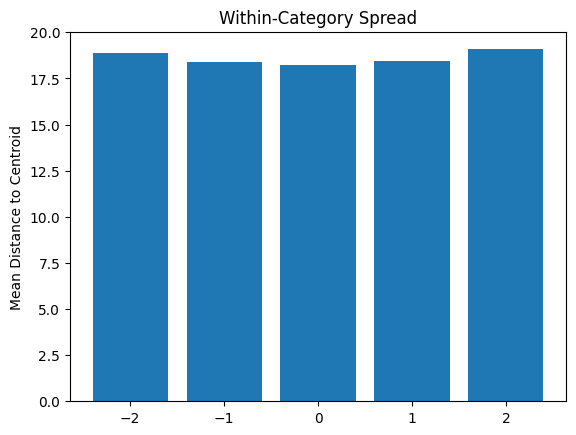

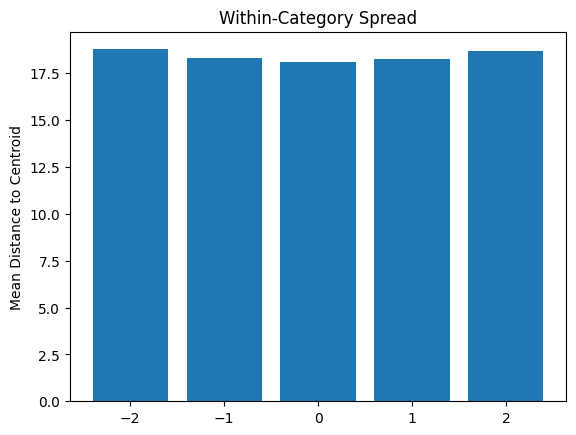

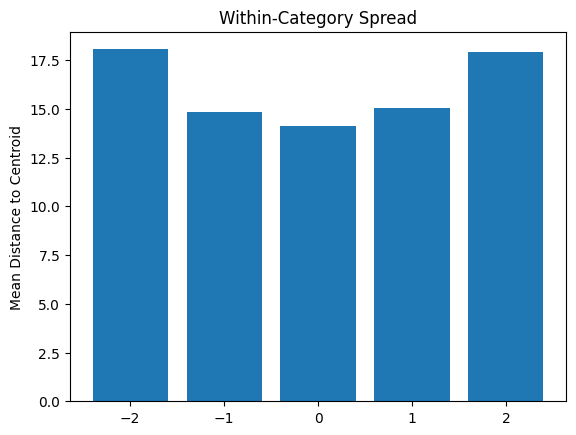

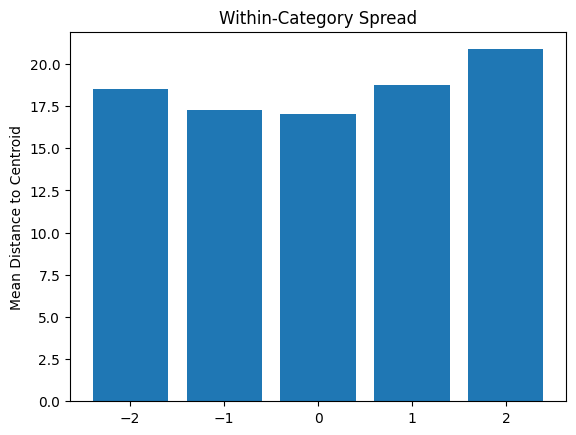

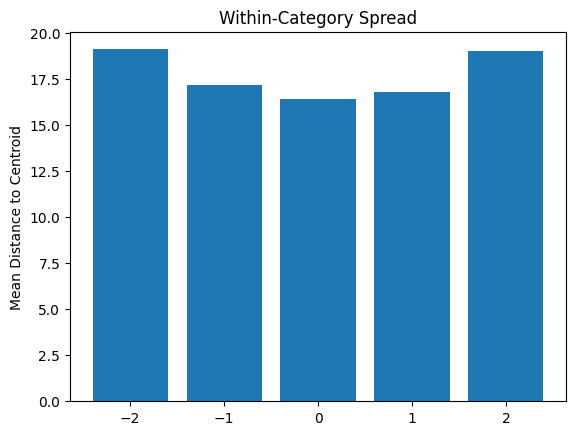

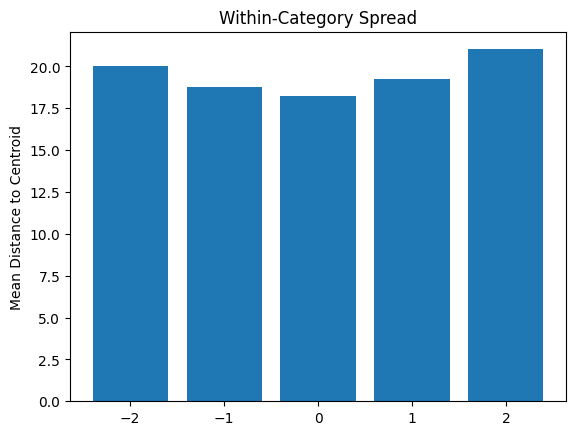

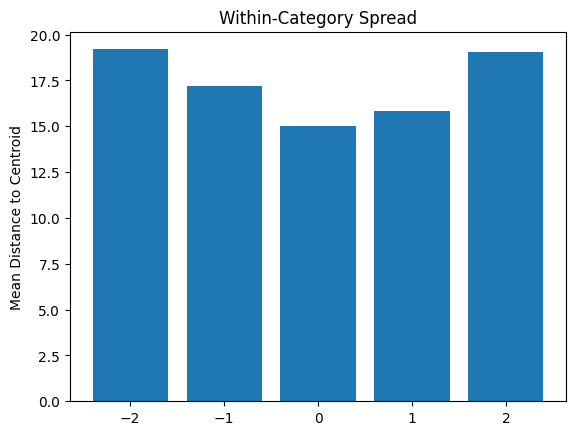

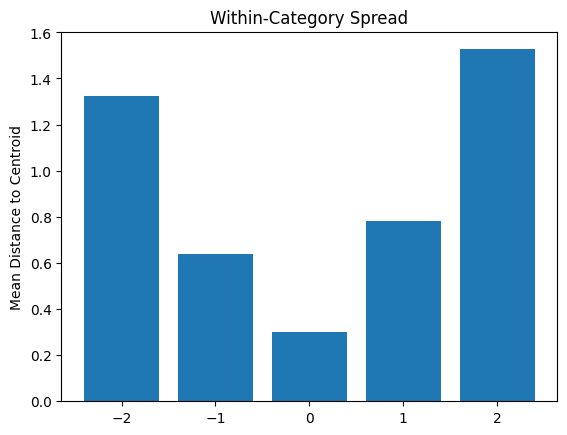

In [173]:
odor_ids = metadata_df['odor'].values
x_ids = metadata_df['x'].values
y_ids = metadata_df['y'].values
h_ids = metadata_df['head_dir'].values

scaler = StandardScaler()

for layer_idx in range(8):

    layer_activations = get_layer_activations(model, state_samples, layer_idx)
    #normalized_acts = normalize(layer_activations, norm='l2')
    normalized_acts = scaler.fit_transform(layer_activations)

    centroids_by_odor = compute_centroids_by_category(normalized_acts, odor_ids)
    centroids_by_x = compute_centroids_by_category(normalized_acts, x_ids)
    centroids_by_y = compute_centroids_by_category(normalized_acts, y_ids)
    centroids_by_hd = compute_centroids_by_category(normalized_acts, h_ids)

    # Odor identity
    odor_labels = list(centroids_by_odor.keys())
    odor_vectors = np.array([centroids_by_odor[oid] for oid in odor_labels])
    odor_distances = cdist(odor_vectors, odor_vectors, metric='euclidean')
    #print(odor_distances)

    x_labels = list(centroids_by_x.keys())
    x_vectors = np.array([centroids_by_x[xid] for xid in x_labels])
 
    y_labels = list(centroids_by_y.keys())
    y_vectors = np.array([centroids_by_y[yid] for yid in y_labels])

    x_distances = cdist(x_vectors, x_vectors, metric='euclidean')
    y_distances = cdist(y_vectors, y_vectors, metric='euclidean')
    xy_distances = cdist(x_vectors, y_vectors, metric='euclidean')
    #print(xy_distances)

    h_labels = list(centroids_by_hd.keys())
    h_vectors = np.array([centroids_by_hd[hid] for hid in h_labels])
    h_distances = cdist(h_vectors, h_vectors, metric='euclidean')
    #print(h_distances)

    odor_head_distances = cdist(odor_vectors, h_vectors, metric='euclidean')

    # sns.heatmap(xy_distances, xticklabels=y_labels, yticklabels=x_labels, annot=True, cmap='Blues')
    # plt.title(f"Layer {layer_idx} Odor-Head Centroid Distance Matrix", fontsize=15)
    # plt.xlabel("Head Direction")
    # plt.ylabel("Odor Cue")
    # #plt.savefig(f'figures/Layer{layer_idx}YCentroidHeatmap.png', dpi=300, bbox_inches = 'tight')
    # plt.show()

    # For each category, compute mean distance of points to centroid
    spread = []
    for cat in x_labels:
        mask = x_ids == cat
        distances = np.linalg.norm(normalized_acts[mask] - centroids_by_x[cat], axis=1)
        spread.append(distances.mean())

    plt.bar(x_labels, spread)
    plt.title("Within-Category Spread")
    plt.ylabel("Mean Distance to Centroid")
    plt.show()



In [ ]:
# SHOW THAT FOR LAYER 7 THE NETWORK TRULY LEANRS HIGHER ACTIVATION FOR ODOR A TURN LEFT AND FOR ODOR B TURN RIGHT
# and then fairly equal activations for No Odor, though I still don't know how it learns to path to No Odor
# and I also want to know how after the initial turn it learn to move forward
# Zoom into 0.9-1 range for Q-value activations

print(centroids_by_odor)

{'No Odor': array([0.9273703, 0.9295692, 0.9295566], dtype=float32), 'Odor A': array([0.9095681, 0.956619 , 0.9086247], dtype=float32), 'Odor B': array([0.9098912 , 0.9093985 , 0.95509166], dtype=float32)}


In [ ]:
# For layer 0, opposite directions have highest centroid distances...kiind of makes sense, agent has a correct spatial orientation...
# Also NE and SW have low centroid distance, corresponding to the clustering of NE and SW...

In [ ]:
# the fact that there's a color gradient for xx distances shows that there's somewhat of a spatial map forming within the x's...
# same for yy distances
# and look at the evenness of the distances, kind of explains the distinct grid...
# also for xy distances you see highest colors at the corners...not sure how to think of this yet


### Centroid Clustering

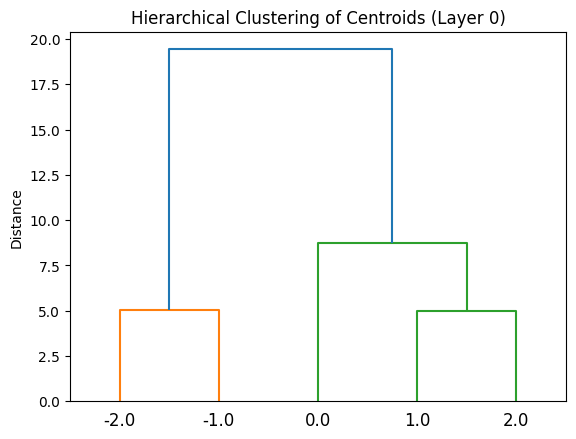

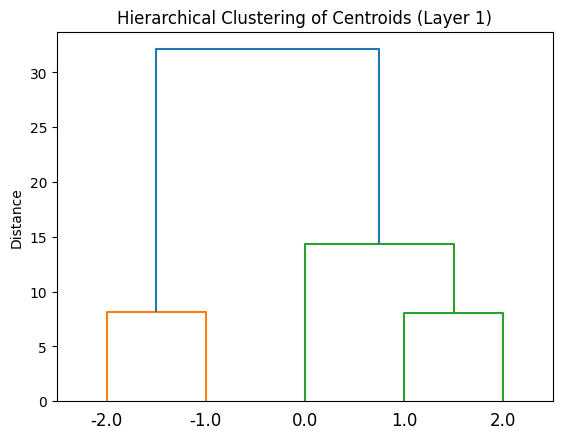

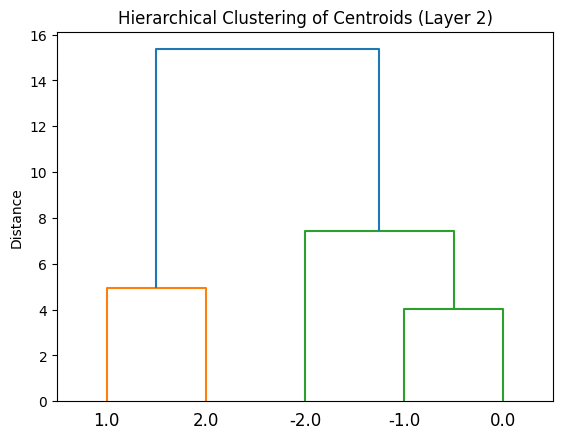

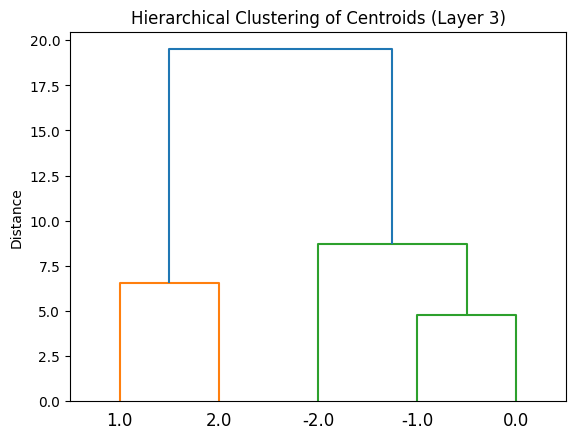

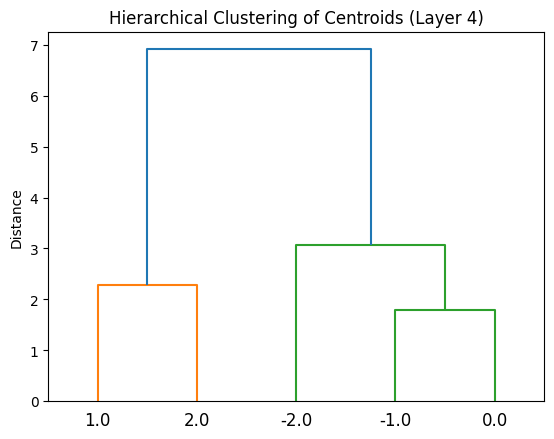

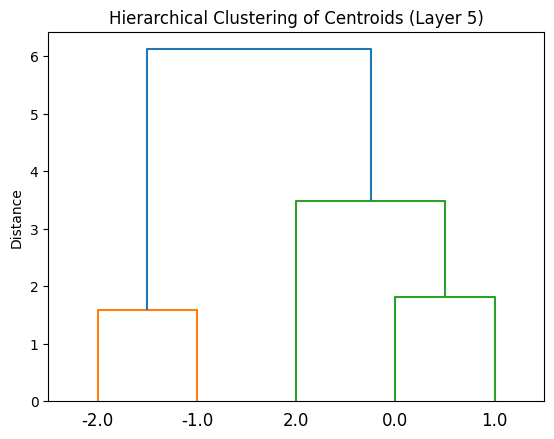

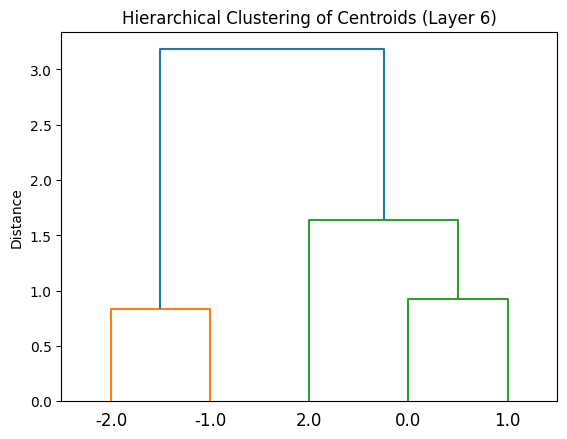

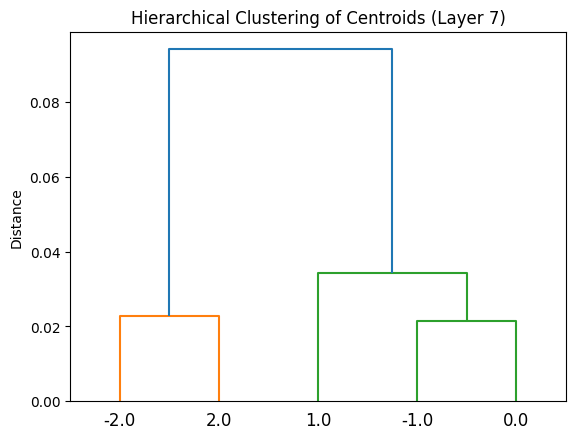

In [176]:
odor_ids = metadata_df['odor'].values
x_ids = metadata_df['x'].values
y_ids = metadata_df['y'].values
h_ids = metadata_df['head_dir'].values


for layer_idx in range(8):



    layer_activations = get_layer_activations(model, state_samples, layer_idx)

    centroids_by_odor = compute_centroids_by_category(layer_activations, odor_ids)
    centroids_by_x = compute_centroids_by_category(layer_activations, x_ids)
    centroids_by_y = compute_centroids_by_category(layer_activations, y_ids)
    centroids_by_hd = compute_centroids_by_category(layer_activations, h_ids)

    centroids = centroids_by_x

    # centroids: dict[category] -> activation vector
    labels = list(centroids.keys())
    vectors = np.array([centroids[label] for label in labels])

    linked = linkage(vectors, method='ward')  # or 'average', 'complete'
    dendrogram(linked, labels=labels)
    plt.title(f"Hierarchical Clustering of Centroids (Layer {layer_idx})")
    plt.ylabel("Distance")
    plt.show()

In [35]:
scaler = StandardScaler()
layer_activations = get_layer_activations(model, state_samples, 0)
normalized_activations = scaler.fit_transform(layer_activations)

In [36]:
layer_activations.shape

(25, 512)

In [39]:
pca = PCA(n_components=1)
reduced = pca.fit_transform(normalized_activations)

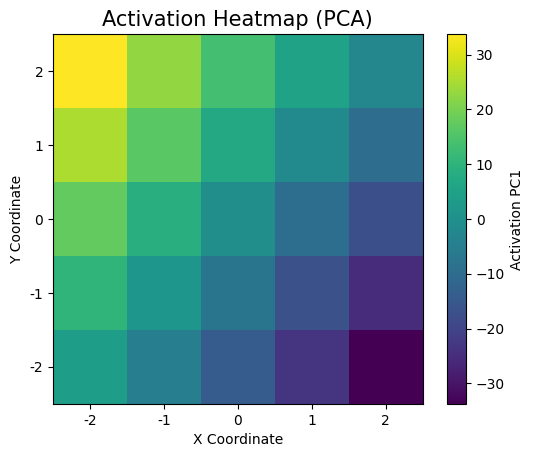

In [47]:
grid = np.zeros((5, 5))
positions = [(x, y) for y in range(2, -3, -1) for x in range(-2, 3)]
for (x, y), value in zip(positions, reduced[:, 0]):
    grid[2 - y, x + 2] = value  # shift coords to index into a 5x5 array

plt.imshow(grid, cmap='viridis')
plt.colorbar(label='Activation PC1')
plt.xticks(ticks=range(5), labels=[-2, -1, 0, 1, 2])
plt.yticks(ticks=range(5), labels=[2, 1, 0, -1, -2])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title("Activation Heatmap (PCA)", fontsize=15)
plt.savefig('figures/activationheatmap.png', dpi=300)
plt.show()

In [46]:
var_ratio = pca.explained_variance_ratio_
print(var_ratio)

[0.52462214]
